<a href="https://colab.research.google.com/github/MarkStephens060482/Big-Data-projects/blob/main/Car_Accident_Severity_EDA_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Severity of Road Accidents
### Mark Stephens

### Exploratory Data Analysis and Visualisation

In [2]:
!pip install Boruta
!pip install category_encoders
!pip install hdbscan
!pip install gower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039188 sha256=bf894f0bfb3cca451c339aaa993ca0fb6c16c65495cf2ee7ee9d738b8405202d
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import os, glob
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

import json
# mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#_________The data files are to be loaded into sub folder of the current working directory called 'data'________
PATH = '/content/drive/MyDrive/Big Data and Industry Project/exploratory data analysis/'
# load the data into a pandas dataframe
files = glob.glob(PATH + "*.csv")
dfs=[]
# read the csv files one at a time and concatenate to a dataframe.
for file in files:
    with open(file,encoding="utf-8") as dataFile:
      df = pd.read_csv(dataFile, index_col = ['ACCIDENT_NO'])
      dfs.append(df)

#read csv files, parse index column and assign to dataframe object
fata_df = dfs[0]
complete_df = dfs[1]

### Road, Vehicle and Participant influences

The state of the road, the number and type of vehicles involved and the number and type of participants involved are examined to explore their influences on the severity of road accidents.

In [5]:
# seperate the possible post-accident target variables.
post_accident_variables_list = ['SEVERITY','INJ_OR_FATAL','FATALITY','SERIOUSINJURY','OTHERINJURY','NONINJURED']
post_accident_variables = complete_df[post_accident_variables_list].copy()
# seperate the pre - accident variables
pre_accident_variables = complete_df.drop(columns = post_accident_variables).copy()
# seperate the numerical and categorical variables
#numeric variables list
pre_accident_numeric_list = pre_accident_variables.select_dtypes(include=np.number).columns.tolist()
#numeric variables
pre_accident_numeric = pre_accident_variables[pre_accident_numeric_list].copy()
#categorical variables
pre_accident_categorical = pre_accident_variables.drop(columns = pre_accident_numeric_list ).copy()
# seperate continuous numeric variables
pre_accident_numeric_continuous = pre_accident_numeric[pre_accident_numeric.select_dtypes(include='float64').columns.tolist()].copy()
# seperate discrete numeric variables
pre_accident_numeric_discrete = pre_accident_numeric.drop(columns = pre_accident_numeric.select_dtypes(include='float64').columns.tolist()).copy()

## Road, Vehicle and Participant Attribute influences
Examine the association of participant counts and type of participants and the severity of the road accident.
A correlation heatmap is produced to identify multicollinearity of variables.

### Participant counts and proportions
Summary statistics, correlation heatmaps and kde plots are observed.

In [6]:
participant_counts_df = pre_accident_numeric_discrete.drop(columns = ['NODE_ID',
                                                                      'NO_OF_VEHICLES',
                                                                      'HEAVYVEHICLE',
                                                                      'PASSENGERVEHICLE',
                                                                      'MOTORCYCLE',
                                                                      'PUBLICVEHICLE'])
participant_counts_df.describe()

,TOTAL_PERSONS,MALES,FEMALES,BICYCLIST,PASSENGER,DRIVER,PEDESTRIAN,PILLION,MOTORIST,UNKNOWN,PED_CYCLIST_5_12,PED_CYCLIST_13_18,OLD_PEDESTRIAN,OLD_DRIVER,YOUNG_DRIVER,UNLICENCSED
count,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000
mean,2.351718,1.300915,0.922172,0.092939,0.486842,1.439598,0.114196,0.005290,0.154931,0.057889,0.009409,0.015688,0.024092,0.070775,0.288968,0.034473
std,1.511044,0.985760,1.055817,0.301104,1.146959,0.902229,0.396258,0.073665,0.370794,0.438522,0.105203,0.130348,0.157470,0.262296,0.510755,0.183972
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,89.000000,30.000000,51.000000,7.000000,85.000000,21.000000,41.000000,2.000000,5.000000,52.000000,8.000000,5.000000,3.000000,3.000000,5.000000,2.000000


Text(0.5, 0.9, 'Figure 16: Heatmap of correlation matrix of participant count variables')

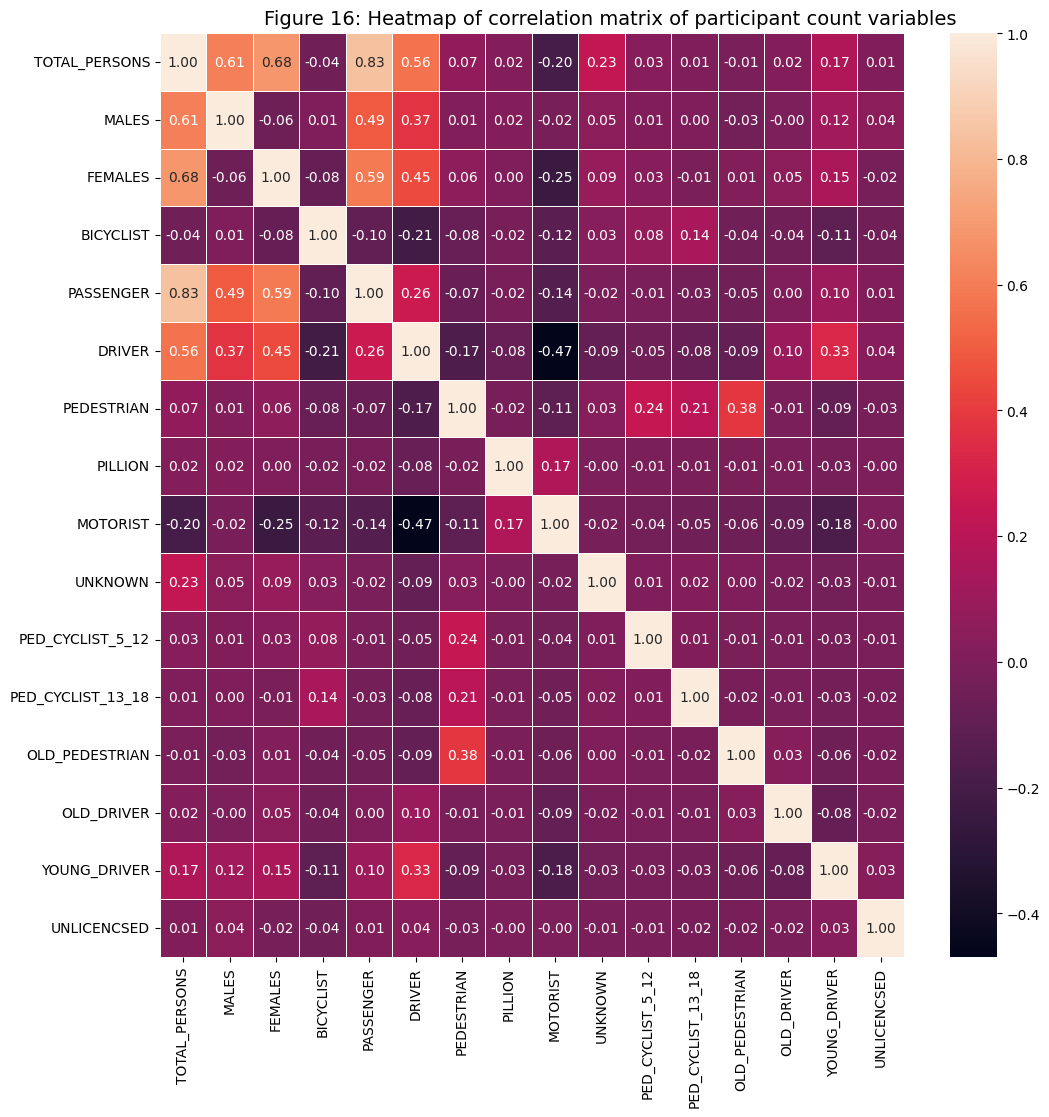

In [7]:
plt.figure(figsize=(12,12))
sns.heatmap(participant_counts_df.corr(),annot = True, fmt='.2f', linewidths=.5)
plt.suptitle("Figure 16: Heatmap of correlation matrix of participant count variables", y = 0.9, size = 14 )

The correlation matrix shows some degree of collinearity between **PASSENGER**, **DRIVER**, **MALES**, **FEMALE** AND **TOTAL_PERSONS**. The sum of the variable values total to **TOTAL_PERSONS**.  

Text(0.5, 0.9, 'Figure 17: Heatmap of correlation matrix of participant proportion variables')

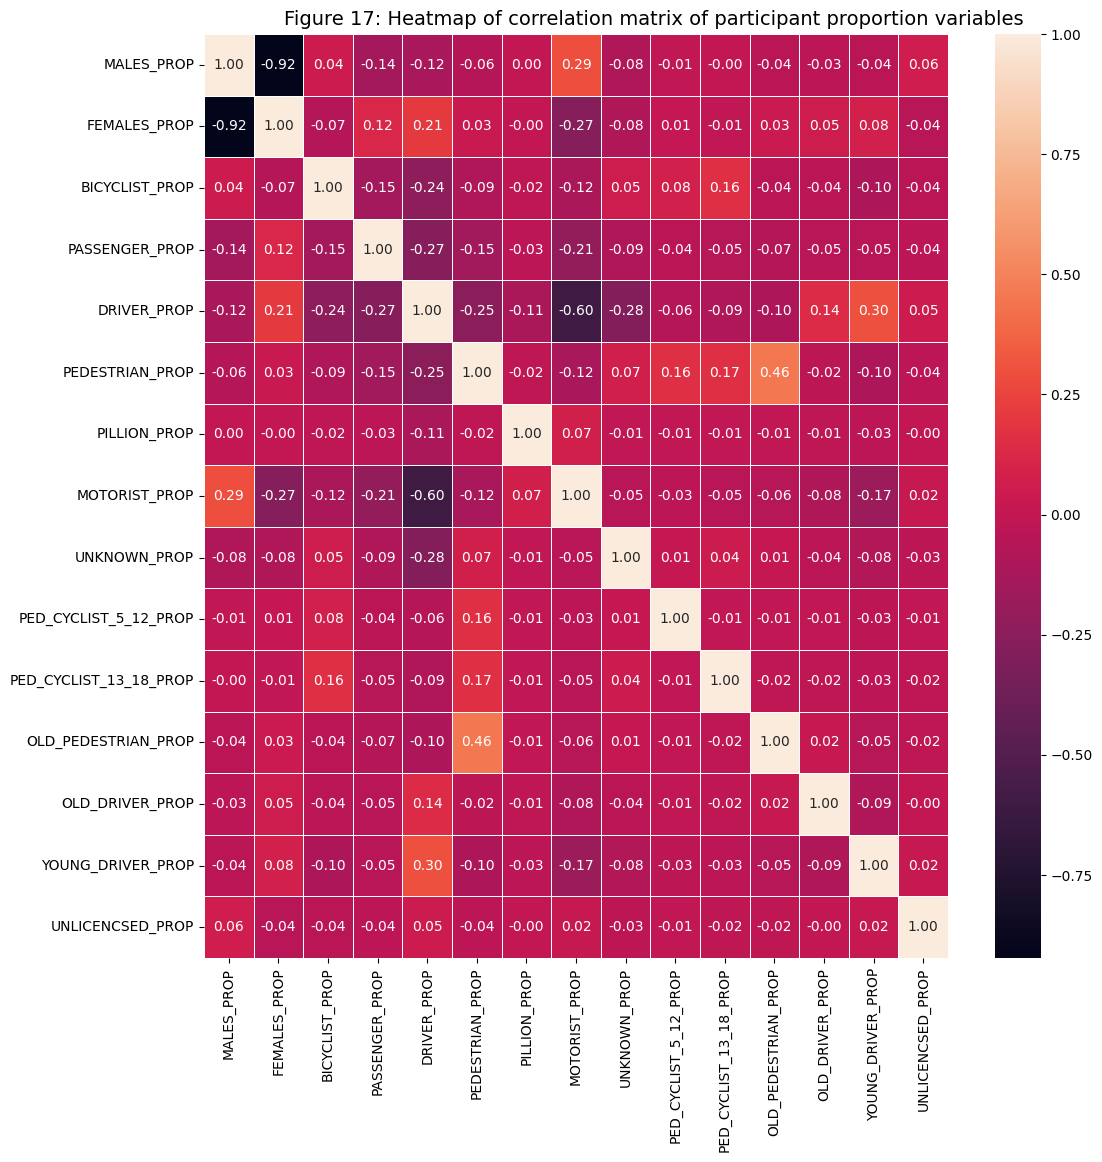

In [8]:
participant_proportions_df = pd.DataFrame()
for col in participant_counts_df.loc[:,'MALES':'UNLICENCSED'].columns:
  participant_proportions_df[col+'_PROP'] = participant_counts_df[col]/participant_counts_df['TOTAL_PERSONS']
plt.figure(figsize=(12,12))
sns.heatmap(participant_proportions_df.corr(),annot = True, fmt='.2f', linewidths=.5)
plt.suptitle("Figure 17: Heatmap of correlation matrix of participant proportion variables", y = 0.9, size = 14 )

The proportions of the variables out of **TOTAL_PERSONS** reduces the correlation between many variable, except for producing strong collinearity between **MALES__PROP** and **FEMALES_PROP**. An increase in collinearity between **DRIVER_PROP** and **MOTORIST_PROP** is also observed.

The association between participant counts, participants proportions and road crash severity is examined.

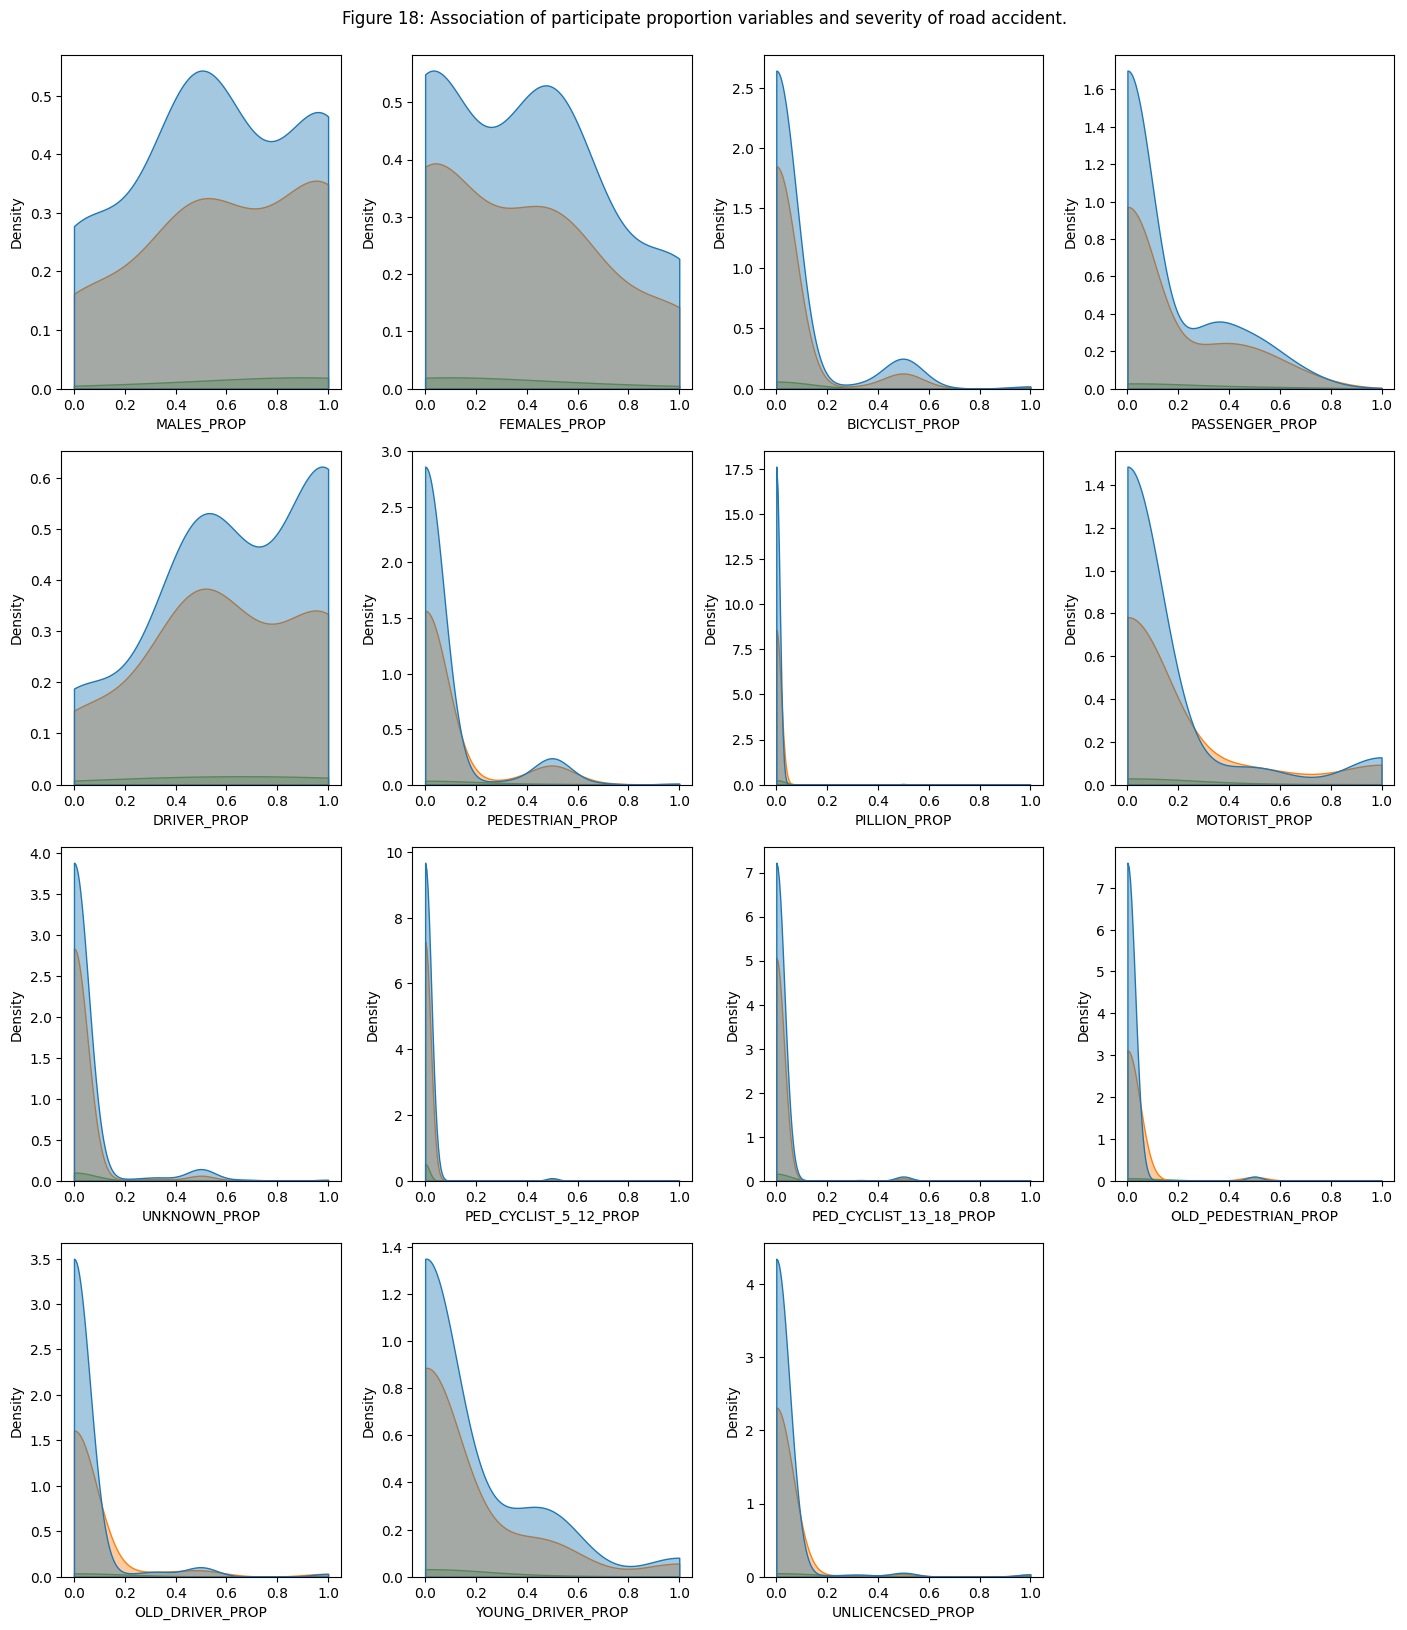

In [9]:
participant_proportions_data = participant_proportions_df.join(post_accident_variables['SEVERITY'])
fig,axs = plt.subplots(4,4, figsize = (14,16))
axs = axs.ravel()
for i,col in enumerate(participant_proportions_df.columns):
  sns.kdeplot(data=participant_proportions_data,
              x = col,
              hue = 'SEVERITY',
              ax = axs[i],
              fill = True,
              bw_adjust=4,
              cut = 0, alpha = 0.4)

  axs[i].get_legend().remove()
h, l = axs[0].get_legend_handles_labels()
plt.suptitle("Figure 18: Association of participate proportion variables and severity of road accident.", y = 1.01)
axs[i+1].remove()
fig.legend(h,l, frameon=False)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

The variables that exhibit near zero variance and have a high instance of zero values are: **PED_CYCLIST_5_12_PROP**, **PED_CYCLIST_13_18_PROP**, **PILLION_PROP**, **OLD_PEDESTRIAN_PROP** and **UNLICENCSED_PROP**. The variables that exhibit collinearity are **MALE_PROP** and **FEMALE_PROP**.

###Vehicle counts and proportions
Summary statistics, correlation heatmaps and kde plots are observed.

In [10]:
vehicle_counts_df = pre_accident_numeric_discrete[['NO_OF_VEHICLES','HEAVYVEHICLE','PASSENGERVEHICLE','MOTORCYCLE','PUBLICVEHICLE']]
vehicle_counts_df.describe()

,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PUBLICVEHICLE
count,60685.000000,60685.000000,60685.000000,60685.000000,60685.000000
mean,1.790854,0.046321,1.411815,0.155689,0.012441
std,0.768843,0.222298,0.931609,0.372030,0.112028
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,0.000000,0.000000
max,21.000000,4.000000,19.000000,5.000000,2.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'HEAVYVEHICLE_PROP'),
  Text(0, 1.5, 'PASSENGERVEHICLE_PROP'),
  Text(0, 2.5, 'MOTORCYCLE_PROP'),
  Text(0, 3.5, 'PUBLICVEHICLE_PROP')])

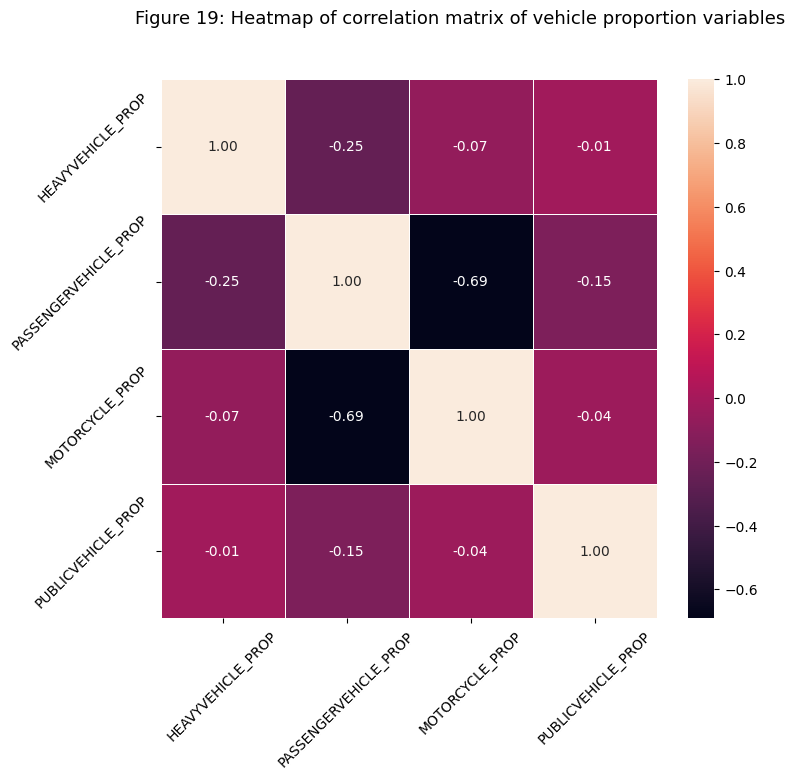

In [11]:
vehicle_proportions_df = pd.DataFrame()
for col in vehicle_counts_df.loc[:,'HEAVYVEHICLE':'PUBLICVEHICLE'].columns:
  vehicle_proportions_df[col+'_PROP'] = vehicle_counts_df[col]/vehicle_counts_df['NO_OF_VEHICLES']
plt.figure(figsize=(8,7))
sns.heatmap(vehicle_proportions_df.corr(),annot = True, fmt='.2f', linewidths=.5)
plt.suptitle("Figure 19: Heatmap of correlation matrix of vehicle proportion variables", y = 0.98, size = 13 )
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

The features **PASSENGERVEHICLE_PROP** and **MOTORCYCLE_PROP** exhibit a moderate degree of collinearity.

The association between vehicle proportions and severity of road accidents is given below:

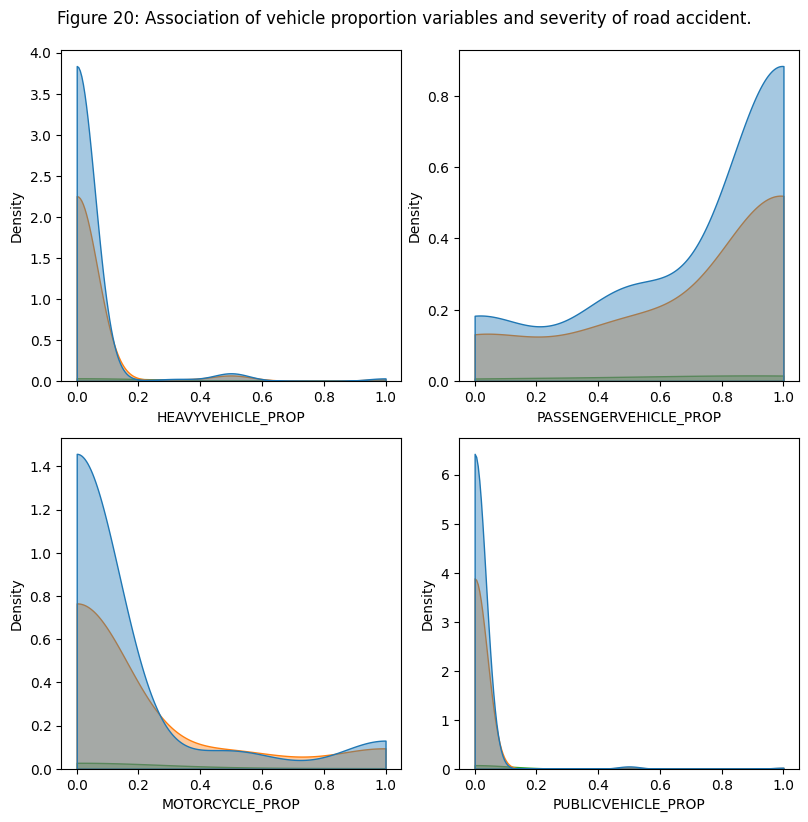

In [12]:
vehicle_proportions_data = vehicle_proportions_df.join(post_accident_variables['SEVERITY'])
fig,axs = plt.subplots(2,2, figsize = (8,8))
axs = axs.ravel()
for i,col in enumerate(vehicle_proportions_df.columns):
  sns.kdeplot(data=vehicle_proportions_data,
              x = col,
              hue = 'SEVERITY',
              ax = axs[i],
              fill = True,
              bw_adjust=4,
              cut = 0, alpha = 0.4)

  axs[i].get_legend().remove()
h, l = axs[0].get_legend_handles_labels()
plt.suptitle("Figure 20: Association of vehicle proportion variables and severity of road accident.", y = 1.01)
fig.legend(h,l, frameon=False)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

##Road conditions and driver attributes categorical variables.
The association of the categorical variables and road accident severity.

In [13]:
road_driver_categories_df= pre_accident_categorical[['HIT_RUN_FLAG','LIGHT_CONDITION','SPEED_ZONE','ALCOHOL_RELATED']].copy()
road_driver_categories_df.describe()

,HIT_RUN_FLAG,LIGHT_CONDITION,SPEED_ZONE,ALCOHOL_RELATED
count,60685,60685,60685,60685
unique,3,7,13,2
top,No,Day,60 km/hr,No
freq,56890,41555,19154,58734


Examine Speed limit as a category. Group low instance of category with another.

In [14]:
road_driver_categories_df.replace('75 km/hr','70 km/hr',inplace = True)

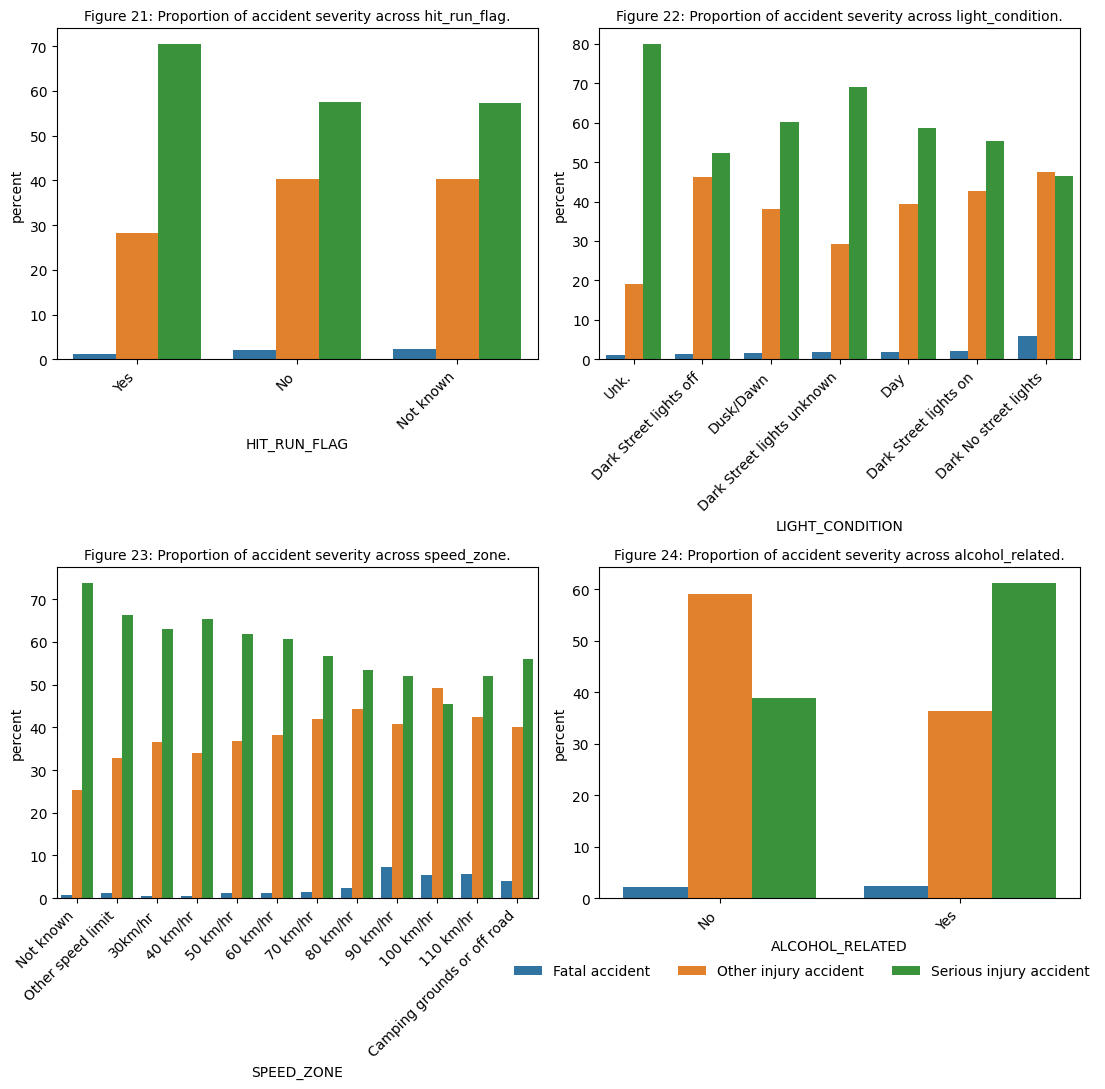

In [15]:
road_driver_categories_data = road_driver_categories_df.join(post_accident_variables['SEVERITY'])
road_driver_categories_data['SPEED_ZONE'] = pd.Categorical(road_driver_categories_data['SPEED_ZONE'],
                                                           categories=['Not known',
                                                                       'Other speed limit',
                                                                       '30km/hr',
                                                                       '40 km/hr',
                                                                       '50 km/hr',
                                                                       '60 km/hr',
                                                                       '70 km/hr',
                                                                       '80 km/hr',
                                                                       '90 km/hr',
                                                                       '100 km/hr',
                                                                       '110 km/hr',
                                                                       'Camping grounds or off road'],
                                                           ordered= True)
fig, axs = plt.subplots(2,2, figsize = (11,11))
axs = axs.ravel()
for i,(road_driver_category,ax) in enumerate(zip(road_driver_categories_data,axs)):
  df = (road_driver_categories_data.groupby(road_driver_category)['SEVERITY']
         .value_counts(normalize = True)
         .mul(100)
         .rename('percent')
         .reset_index())
  df = df.sort_values('percent')
  sns.barplot(x=road_driver_category, y = 'percent', hue='SEVERITY', data=df, ax = ax)
  ax.get_legend().remove()
  ax.set_title(f'Figure {21+i}: Proportion of accident severity across {road_driver_category.lower()}.', size = 10)
  ax.set_xticklabels(axs[i].get_xticklabels(),  rotation = 45, ha="right")

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels,loc='lower right', bbox_to_anchor = (1,0.1,0,0.1), ncol=3,
              borderaxespad=0, frameon=False)
plt.tight_layout()
# show the graph
plt.show()

Figure 23 shows that **SPEED-ZONE** has a clear affect on the severity of the road accidents across all three classes. The categorical bariable **HOT_AND_RUN_FLAG** also has an effect on **SEVERITY** though to a lesser extent for the Fatal Accident class. The **HIT_AND_RUN_FLAG** variable has class 'Not known', which is not clearly interpretibe and could be merged with the 'No' class as it shares a near similar distribution. **ALCOHOL_RELATED** exhibits an association with accident SEVERITY with clear variation between Other injury accident and Serious injury accident classes

In [16]:
road_driver_categories_df['HIT_RUN_FLAG'].replace('Not known','No',inplace = True)
road_driver_categories_df['HIT_RUN_FLAG'].value_counts(normalize = True)

No     0.94221
Yes    0.05779
Name: HIT_RUN_FLAG, dtype: float64

## Feature Engineering, Preprocessing and Feature Selection for Unsupervised and Supervised learning.

Based on the results of the above exploratory data analysis, a number of features are to be engineers and undergo further processing. The data is then to be preprocessed by scaling and normalising numerical variables, and encoding nominal and ordinal variables accordingly.

In [17]:
from pandas.api.types import CategoricalDtype
# Seperate data into features and Target variable data sets.
y = post_accident_variables['SEVERITY']
# Construct candidate features set
candidate_features = pd.concat([pre_accident_numeric_continuous,
                                participant_proportions_df,
                                vehicle_proportions_df,
                                road_driver_categories_data.iloc[:,:-1],
                                pre_accident_categorical.drop(columns = road_driver_categories_data.columns[:-1])], axis = 1)

#Remove Logotide and Latitude and keep as seperate dataframe
Log_lat_coords_df = candidate_features[['LONGITUDE','LATITUDE']]

# Drop irrelevant variables
candidate_features = candidate_features.drop(columns = ['LONGITUDE','LATITUDE'])

#Transform the precipitation variable using log.
offset = candidate_features['precip'].where(lambda x: x > 0).min()/2
candidate_features['log_precip'] = candidate_features['precip'].apply(lambda x: np.log(x + offset))

# Order the categories of Day of the week to ensure it is ordinal.
candidate_features['DAY_OF_WEEK'] = candidate_features['DAY_OF_WEEK'].astype(CategoricalDtype(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    ordered=True))

#Identify the Month as a feature
candidate_features['Month'] = pd.to_datetime(candidate_features['ACCIDENT_DATE']).dt.month
candidate_features['Month'] = candidate_features['Month'].astype(CategoricalDtype(ordered=True))
#Identify the Hour of the day as a feature
candidate_features['Hour'] = pd.to_datetime(candidate_features['ACCIDENT_TIME']).dt.hour
candidate_features['Hour'] = candidate_features['Hour'].astype(CategoricalDtype(ordered=True))

#Drop unnecessary variables
candidate_features = candidate_features.drop(columns = ['precip','ACCIDENT_TIME','ACCIDENT_DATE'])


## Feature Importance and Feature Selection
The feature selection strategy includes:
1. Preprocess the candidate feature space by encoding categorical variables in the following manner:
*   ordinal variables - ordinal encoding  
*   nominal variables (low cardinality) - OneHot encoding
*   nominal variables (high cardinality) - multiclass Target encoding
*   scale numerical variables using robust scaler.
The One Hot encoding features will have one category dropped for the Logistic base model.

2. Detecting multicollinearity using Variance Inflation Factor (VIF) and reducing its effect my removing relevant variables. This also reduces dimensionality.

3. Fit a Logistic and Decision Tree base model with appropriate preprocessed feature set and evaluate Feature Importance.

4. Perform feature selection via Boruta Algorithm, using Random Forest as the estimator.

### Preprocessing and Feature Selection

The data is preprocessed to be used on the Baruto Algorithm for feature selection. The numerical variables are scaled. The ordinal categorical variables are ordinal encoded while the nominal variable are One Hot encoded. The nominal variable with high cardinality is initially consolidated based on the given threshold.

In [18]:
import category_encoders as ce
from collections import Counter
from sklearn.preprocessing import RobustScaler,StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(transform_output = "pandas")

#define the preprocessing of high cardinality categorical variable.
def categorical_consolidation(column,threshold = 0.995):

  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)
  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break

  #Replace all instances not in our new categories by Other
  new_column=column.where(column.isin(categories_list),other = 'OTHER')
  #Return the transformed column if return_categories=False
  return new_column

#X,y are pandas df and series
def target_encode_multiclass(X,y,col_name,drop = False):
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj = X[col_name] #separate categorical columns
    X = X.drop(col_name,axis=1)
    for i,class_ in enumerate(class_names):
        enc=TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #convert all categorical
        temp=enc.transform(X_obj)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X=pd.concat([X,temp],axis=1)    #add to original dataset
    if drop:
      X = X.iloc[:,:-1]
    return X

##Encoding and preprocessing columns##
#Initialise scalers
st_scaler = StandardScaler()
rb_scaler = RobustScaler()
#Initialise encoders
oh_encoder1 = OneHotEncoder(sparse_output=False,handle_unknown = 'ignore')
oh_encoder2 = OneHotEncoder(sparse_output=False, drop = 'first',handle_unknown = 'ignore')
ord_encoder = OrdinalEncoder()

#define the preprocessing for Tree base model
preprocessor1 = ColumnTransformer(
    [("ordinal_encoder",ord_encoder,make_column_selector(dtype_include="category")),
     ("nominal_encoder",oh_encoder1,make_column_selector(dtype_include=object))],
    remainder = 'passthrough')

#define the preprocessing for Logistic base model
column_trans1 = ColumnTransformer(
    [("ordinal_encoder",ord_encoder,make_column_selector(dtype_include="category")),
     ("nominal_encoder",oh_encoder2,make_column_selector(dtype_include=object))],
    remainder = 'passthrough')
preprocessor2 = make_pipeline(column_trans1,rb_scaler)


Process the data accordingly for Feature Selection.

In [19]:
feature_select_df = candidate_features.copy()
# Transform the high cardinality nominal variable by categorical feature consolidation
thres = 0.97
feature_select_df['LGA_NAME'] = categorical_consolidation(feature_select_df['LGA_NAME'],threshold = thres)
# Further transform the high cardinality nominal variable by Multiclass Target Encoding.
feature_select_df = target_encode_multiclass(feature_select_df,y,'LGA_NAME',drop = True)
# scale numerical variables
feature_select_df = preprocessor2.fit_transform(feature_select_df)

## Variance Inflation Factor
The data set is preprocessed for encoding high cardinality nominal variables.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = feature_select_df.columns
vif_data["feature"]=vif_data["feature"].apply(lambda x: x.split('__')[1])
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(feature_select_df.values, i)
                          for i in range(len(feature_select_df.columns))]
vif_data.sort_values(by = "VIF", ascending = False, inplace = True)
vif_data[vif_data["VIF"] > 5]

,feature,VIF
33,DRIVER_PROP,9932.753192
36,MOTORIST_PROP,8314.820350
32,PASSENGER_PROP,5004.648592
14,REGION_NAME_METROPOLITAN SOUTH EAST REGION,3273.107199
13,REGION_NAME_METROPOLITAN NORTH WEST REGION,3201.894499
19,STAT_DIV_NAME_Metro,2875.169220
34,PEDESTRIAN_PROP,2346.921769
31,BICYCLIST_PROP,2226.490995
37,UNKNOWN_PROP,1047.069016
22,feelslike,99.029194


Drop obvious variables that are highly correlated and may not provide additional information for fitting ase Logistic Model and decision tree model.

In [21]:
preprocessor3 = make_pipeline(
    make_column_transformer(('drop',['FEMALES_PROP','feelslike','UNKNOWN_PROP','MOTORIST_PROP']),
                            remainder = 'passthrough'),
    preprocessor2)
preprocessor3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['FEMALES_PROP', 'feelslike',
                                                   'UNKNOWN_PROP',
                                                   'MOTORIST_PROP'])])),
                ('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x79c620091060>),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x79c6200911e0>)])),
                                 ('robustscaler', RobustScaler())]))])

### Base models of Decision Tree and Logistic regression
Baseline models using a decision tree and simple logistic regression with  preprocessed dataset are established. The data is split into training and testing set. The accuracy and feature importance are determined.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(candidate_features, y, test_size=0.2, stratify = y, random_state=42)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#Define the base models
tree_classifier = DecisionTreeClassifier(class_weight = 'balanced',
                                         random_state=20)
Log_classifier = LogisticRegression(class_weight = 'balanced',
                                    n_jobs = -1,
                                    multi_class = 'multinomial')

# preprocess high cardinality nominal variable for training and testing set
thres = 0.97
#training set
X_train['LGA_NAME'] = categorical_consolidation(X_train['LGA_NAME'],threshold = thres)
X_train_trans = target_encode_multiclass(X_train,y_train,'LGA_NAME',drop = True)
#testing set
X_test['LGA_NAME'] = categorical_consolidation(X_test['LGA_NAME'],threshold = thres)
X_test_trans = target_encode_multiclass(X_test,y_test,'LGA_NAME',drop = True)

# define the base Decision Tree model pipline
basemodel1_pipeline = make_pipeline(preprocessor1,tree_classifier)
# define the base Logistic model pipline
basemodel2_pipeline = make_pipeline(preprocessor3,Log_classifier)


Fit the Base models and examine their Feature Importance.

<ipython-input-24-9ed834ffbe75>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation = 45,ha="right")
<ipython-input-24-9ed834ffbe75>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation = 45,ha="right")
<ipython-input-24-9ed834ffbe75>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation = 45,ha="right")
<ipython-input-24-9ed834ffbe75>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation = 45,ha="right")


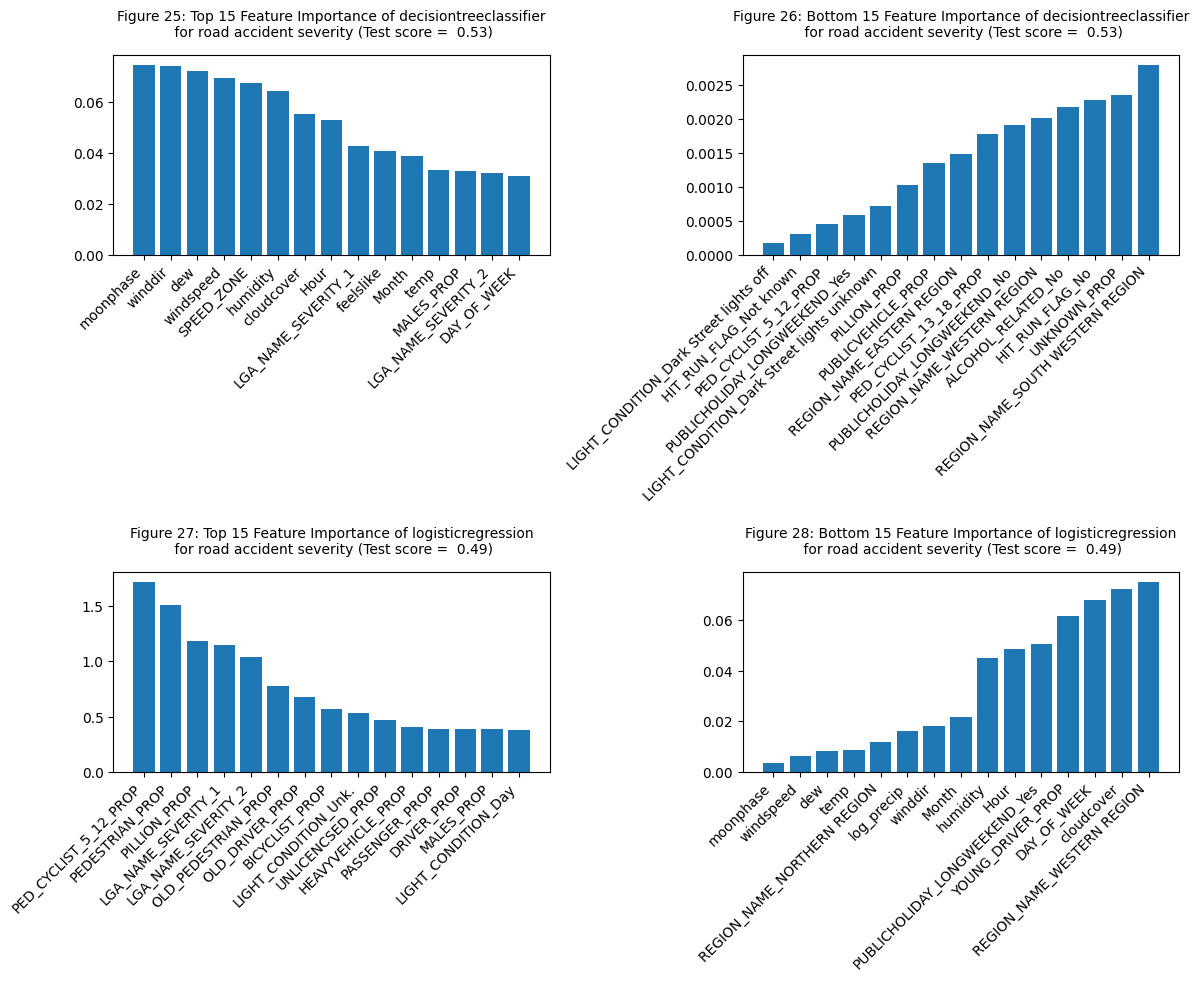

In [24]:
n = 15
new_line = '\n'
fig,axs = plt.subplots(2,2,figsize = (12,10))
axs = axs.ravel()
model_direction = [(basemodel1_pipeline,False),
                   (basemodel1_pipeline,True),
                   (basemodel2_pipeline,False),
                   (basemodel2_pipeline,True)]
for i,(pipe,direction) in enumerate(model_direction):
  # fit the model pipeline
  pipe.fit(X_train_trans, y_train)
  # get importance
  if pipe.steps[-1][0] == 'decisiontreeclassifier':
    importance = pipe.steps[-1][1].feature_importances_
     #extract feature names
    vectorize_split = np.vectorize(lambda x: x.split('__')[1])

  else:
    importance = np.mean(np.abs(pipe.steps[-1][1].coef_),axis = 0)
    vectorize_split = np.vectorize(lambda x: x.split('__')[2])
  #  classes
  classes = pipe.steps[-1][1].classes_
  # Scores
  score = pipe.score(X_test_trans, y_test)
  #extract feature names
  model_cols = vectorize_split(pipe.steps[-1][1].feature_names_in_)
  #prepare feature importance data as dataframe
  importance_data = pd.DataFrame([importance],columns = model_cols)
  long_importance_data = pd.melt(importance_data,value_vars = importance_data.columns[:])
  #sort dataframe by feature importance score
  long_importance_data_sorted = long_importance_data.sort_values(by = 'value', ascending = direction ).head(n)
  # plot feature importance
  axs[i].bar(x = 'variable', height = 'value', data = long_importance_data_sorted)
    # Rotating X-axis labels
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation = 45,ha="right")
  axs[i].set_title(f'Figure {25+i}: {["Bottom" if direction else "Top"][0]} {n}\
 Feature Importance of {pipe.steps[-1][0]}{new_line} for road accident severity (Test score = {score: 0.2f})',y=1.05, size = 10)
plt.tight_layout()
plt.show()

The feature Importance of the base models show some inconsistences due to the prevalent multicollinearity affecting the Logistic Regression. However, common features that are significantly importanty across both models are **MALE_PROP**, and the encoded **LGA_NAME** variable. The decision tree base model, demonstrating an improvement in test accuracy of 53%, also deems some meteorological feature important.  

# Automated Feature Selection - Boruta Algorithm
The boruta algorithm accepts all variables that are regarded as important to explaining the target variable, including highly correlated features, which don't necessarily contribute further information. Therefore, the correlated features identified and selected from VIF are to be removed, with categorical variables encoded appropriately.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
#processing for Boruta
X_train_trans1 = preprocessor3.fit_transform(X_train_trans)

rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth = 7, min_samples_leaf = 2, class_weight='balanced')
boruta_selector = BorutaPy(rfc, n_estimators='auto', max_iter=100, perc = 85)

boruta_selector.fit(np.array(X_train_trans1), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=7,
                                          min_samples_leaf=2, n_estimators=85,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x79C6721B3640),
         n_estimators='auto', perc=85,
         random_state=RandomState(MT19937) at 0x79C6721B3640)

In [26]:
boruta_columns = X_train_trans1.loc[:,boruta_selector.support_].columns
boruta_columns = boruta_columns.map(lambda x: x.split('__')[2])
boruta_X_train = boruta_selector.transform(np.array(X_train_trans1))
boruta_X_train = pd.DataFrame(boruta_X_train,columns = boruta_columns)

THe Boruta Algorithm gives support to a subset of features that it deems important and rejects features that it deems to have weak support

Text(0.5, 1.0, 'Figure 29: The feature rank score as selected by the Boruta Algorithm.')

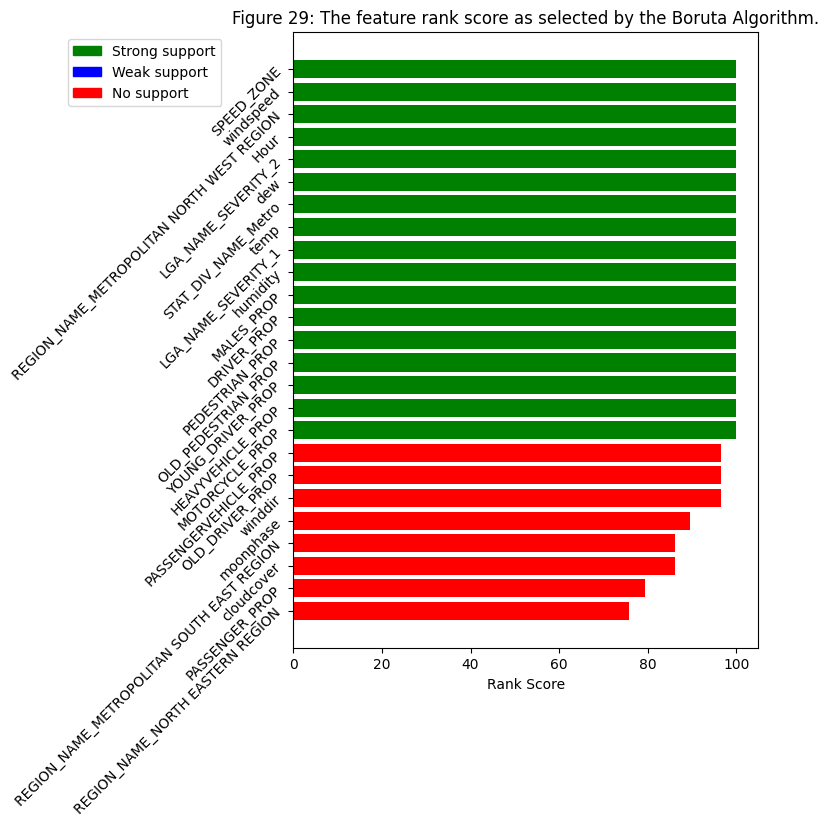

In [27]:
from operator import add
import matplotlib.patches as mpatches
index_order = np.argsort(boruta_selector.ranking_)
weak = [1 if x else 0 for x in boruta_selector.support_weak_[index_order]]
strong = [2 if x else 0 for x in boruta_selector.support_[index_order]]
result = list(map(add, weak, strong))

boruta_selection = pd.DataFrame(np.c_[X_train_trans1.columns[index_order],
                                boruta_selector.ranking_[index_order],
                                result],
                                columns = ['feature','Rank', 'Support'])

boruta_selection['feature'] = boruta_selection['feature'].map(lambda x: x.split('__')[2])
boruta_selection['Support'] = boruta_selection['Support'].replace({0:"no",1:"weak",2:"strong"})
boruta_selection['Rank'] = boruta_selection['Rank'].astype(int)
maxrank = boruta_selection['Rank'].max()

boruta_selection['Rank'] = boruta_selection.eval("100 - ((Rank-1)/(@maxrank-1))*100")
boruta_selection = boruta_selection.sort_values(by = "Rank",ascending=True)
color = ['g' if x=='strong' else 'b' if x == 'weak' else 'r' for x in  boruta_selection['Support'].tail(25)]
red_patch = mpatches.Patch(color='r', label='No support')
green_patch = mpatches.Patch(color='g', label='Strong support')
blue_patch = mpatches.Patch(color='b', label='Weak support')

plt.figure(figsize = (6,8))
plt.barh(y = 'feature', width = 'Rank', color = color, data = boruta_selection.tail(25) )
plt.legend(handles=[green_patch,blue_patch,red_patch], loc = 'upper left', bbox_to_anchor=(-0.5, 1.0))
plt.yticks(rotation = 45,ha="right")
plt.xlabel("Rank Score")
plt.title('Figure 29: The feature rank score as selected by the Boruta Algorithm.')

##Clustering of Road Accident Characteristics and geographical trends.
Hierarchical Density-based Spatial Clustering of Applications with Noise (HDBSCAN) with Gower distance metric for mixed datatypes is employed as the clustering strategy.
Gower Distance - Used for measuring similarity between instances in data containing a mix of numerical and categorical features.


In [40]:
import hdbscan
import gower
from sklearn.manifold import TSNE

clustering_data = candidate_features.copy()
cat_columns = clustering_data.select_dtypes(include='category').columns
for cat in cat_columns:
 clustering_data[cat] = clustering_data[cat].astype(object)
# preprocess dataset for embedding a t-SNE manifold
clustering_data['LGA_NAME'] = categorical_consolidation(clustering_data['LGA_NAME'],threshold = thres)

#sampling data set for visualisation
clustering_data_sample = clustering_data.sample(frac= 0.2, random_state = 42)
#calculate the gower distance
gower_distance = gower.gower_matrix(clustering_data_sample)

Project the High-Dimensional dataset to a 2D visualisation using t-distributed Stochastic Neighbor Embedding (t-SNE).

<ipython-input-60-eff80c377d8c>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*projection.T, s=5, linewidth=0, c=cluster_member_colors, cmap="cmap_name_r", alpha=0.40)


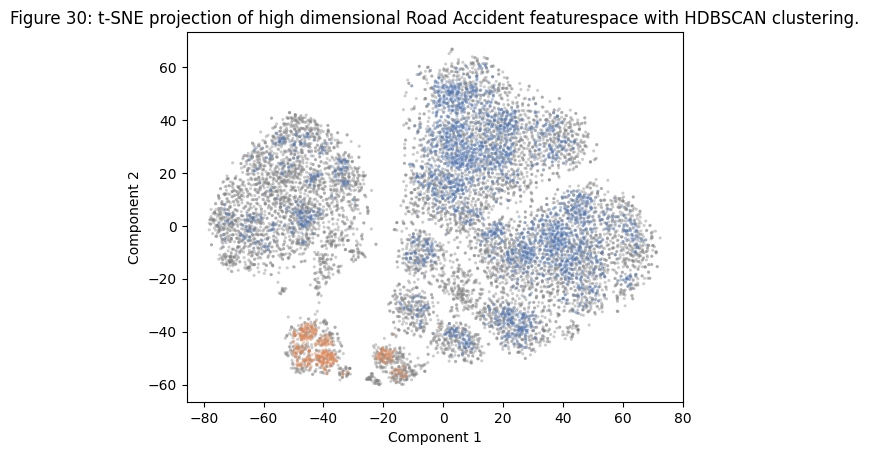

In [60]:
fig = plt.figure()

projection = TSNE(n_components=2,
                  learning_rate='auto',
                  init='random',
                  perplexity=50,
                  metric = 'precomputed',
                  n_iter = 1500).fit_transform(gower_distance)

clusterer = hdbscan.HDBSCAN(metric = "precomputed",
                            min_cluster_size=75 ,
                            min_samples= 2).fit(np.float64(gower_distance))
color_palette = sns.color_palette('deep', 12)

cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=5, linewidth=0, c=cluster_member_colors, cmap="cmap_name_r", alpha=0.40)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Figure 30: t-SNE projection of high dimensional Road Accident featurespace with HDBSCAN clustering.')
plt.show()


In [78]:
clustering_results = pd.DataFrame(np.c_[y.loc[clustering_data_sample.index],
                                        clustering_data_sample['STAT_DIV_NAME'],
                                        clusterer.labels_],
                                  columns = ['Severity','STAT_DIV_NAME','Clustering label'])
replace_dict = {-1:'outlier',0:'cluster 1',1:'cluster 2'}
clustering_results = clustering_results.replace({'Clustering label':replace_dict})
clustrering_severity_proportions = (clustering_results.groupby('Clustering label')['STAT_DIV_NAME']
                                    .value_counts(normalize = True)
                                    .mul(100)
                                    .rename('percentage')
                                    .reset_index())
clustrering_severity_proportions

,Clustering label,STAT_DIV_NAME,percentage
0,cluster 1,Metro,87.518949
1,cluster 1,Country,12.481051
2,cluster 2,Country,76.045627
3,cluster 2,Metro,23.954373
4,outlier,Metro,63.373840
5,outlier,Country,36.626160
